# -In depth data analysis preoject-
---

+ reading the taxi trip & zones data and merging them

In [1]:
import pandas as pd

# Load zone lookup data
df_zones = pd.read_csv('taxi_zone_lookup.csv')
df_zones.columns = df_zones.columns.str.strip()
df_zones['LocationID'] = df_zones['LocationID'].astype(str)
df_zones['Borough'] = df_zones['Borough'].str.strip()
df_zones['Zone'] = df_zones['Zone'].str.strip()
df_zones['service_zone'] = df_zones['service_zone'].str.strip().str.lower()
df_zones['service_zone'] = df_zones['service_zone'].replace({'boro zone': 'borough zone'})

# Load trip data
df_trips = pd.read_parquet('yellow_tripdata_2025-01.parquet')
df_trips.columns = df_trips.columns.str.strip()

# Convert location IDs to string in trip data to match zone data
df_trips['PULocationID'] = df_trips['PULocationID'].astype(str)
df_trips['DOLocationID'] = df_trips['DOLocationID'].astype(str)

# Merge pickup location info
df_merged = pd.merge(df_trips, df_zones, 
                    left_on='PULocationID', 
                    right_on='LocationID',
                    how='left')

# Rename the zone columns for pickup location
df_merged = df_merged.rename(columns={
    'Borough': 'PUBorough',
    'Zone': 'PUZone',
    'service_zone': 'PUservice_zone'
})

# Merge dropoff location info
df_merged = pd.merge(df_merged, df_zones, 
                    left_on='DOLocationID', 
                    right_on='LocationID',
                    how='left')

# Rename the zone columns for dropoff location
df_merged = df_merged.rename(columns={
    'Borough': 'DOBorough',
    'Zone': 'DOZone',
    'service_zone': 'DOservice_zone'
})

# Drop the extra LocationID columns from the merges
df_merged = df_merged.drop(columns=['LocationID_x', 'LocationID_y'])

# Display results
print(df_merged.head())
print(df_merged.info())
print(df_merged.isnull().sum())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2025-01-01 00:18:38   2025-01-01 00:26:59              1.0   
1         1  2025-01-01 00:32:40   2025-01-01 00:35:13              1.0   
2         1  2025-01-01 00:44:04   2025-01-01 00:46:01              1.0   
3         2  2025-01-01 00:14:27   2025-01-01 00:20:01              3.0   
4         2  2025-01-01 00:21:34   2025-01-01 00:25:06              3.0   

   trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
0           1.60         1.0                  N          229          237   
1           0.50         1.0                  N          236          237   
2           0.60         1.0                  N          141          141   
3           0.52         1.0                  N          244          244   
4           0.66         1.0                  N          244          116   

   payment_type  ...  total_amount  congestion_surcharge  Airport_fee  \
0            

-> as we can notice here there exist a bunch of missing values that needs to be treated!

+ cleaning data

In [2]:
# 1. First replace 'Unknown' with NaN so they can be properly imputed
df_merged.replace('Unknown', pd.NA, inplace=True)

# 2. Handle missing zone information by filling with mode (most frequent value)
print("Missing values before cleaning:")
print(df_merged[['PUBorough', 'DOBorough']].isnull().sum())

# Calculate modes for each column (excluding current NaN values)
puborough_mode = df_merged['PUBorough'].mode()[0]
puzone_mode = df_merged['PUZone'].mode()[0]
dorough_mode = df_merged['DOBorough'].mode()[0]
dozone_mode = df_merged['DOZone'].mode()[0]

# Fill missing values with mode
df_merged['PUBorough'] = df_merged['PUBorough'].fillna(puborough_mode)
df_merged['PUZone'] = df_merged['PUZone'].fillna(puzone_mode)
df_merged['DOBorough'] = df_merged['DOBorough'].fillna(dorough_mode)
df_merged['DOZone'] = df_merged['DOZone'].fillna(dozone_mode)

# 3. Clean numeric columns
# Convert passenger_count to integer and fill missing with mode
passenger_mode = int(df_merged['passenger_count'].mode()[0])
df_merged['passenger_count'] = df_merged['passenger_count'].fillna(passenger_mode).astype(int)

# Handle trip_distance outliers
df_merged = df_merged[(df_merged['trip_distance'] > 0.05) & 
                     (df_merged['trip_distance'] < 50)]

# 4. Clean datetime columns
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])
df_merged['tpep_dropoff_datetime'] = pd.to_datetime(df_merged['tpep_dropoff_datetime'])

# Remove invalid time sequences
df_merged = df_merged[df_merged['tpep_pickup_datetime'] < df_merged['tpep_dropoff_datetime']]

# 5. Handle payment and fare anomalies
payment_mode = df_merged['payment_type'].mode()[0]
df_merged['payment_type'] = df_merged['payment_type'].fillna(payment_mode).astype('category')

# Remove negative fares
df_merged = df_merged[df_merged['total_amount'] > 0]

# 6. Handle same pickup/dropoff locations
same_loc_trips = df_merged[df_merged['PULocationID'] == df_merged['DOLocationID']]
print(f"Trips with identical pickup/dropoff: {len(same_loc_trips)}")

# 7. Final validation
print("\nCleaned data summary:")
print(f"Total rows: {len(df_merged)}")
print("Missing values after cleaning:")
print(df_merged[['PUBorough', 'DOBorough']].isnull().sum())

# 8. Save to CSV with additional optimizations
# Convert categorical to string for cleaner CSV output
df_merged['payment_type'] = df_merged['payment_type'].astype(str)


print("Data successfully cleaned")

Missing values before cleaning:
PUBorough     9521
DOBorough    24062
dtype: int64
Trips with identical pickup/dropoff: 138072

Cleaned data summary:
Total rows: 3307371
Missing values after cleaning:
PUBorough    0
DOBorough    0
dtype: int64
Data successfully cleaned


- after successfuly cleaning the data and saving it, lets start doing some insightful visualization and analysis!

- first lets take a look at our new columns.

In [3]:
df_merged.columns  # Display the columns of the cleaned data


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'PUBorough', 'PUZone', 'PUservice_zone',
       'DOBorough', 'DOZone', 'DOservice_zone'],
      dtype='object')

+ we interest this time by the number of taxi trips each day.

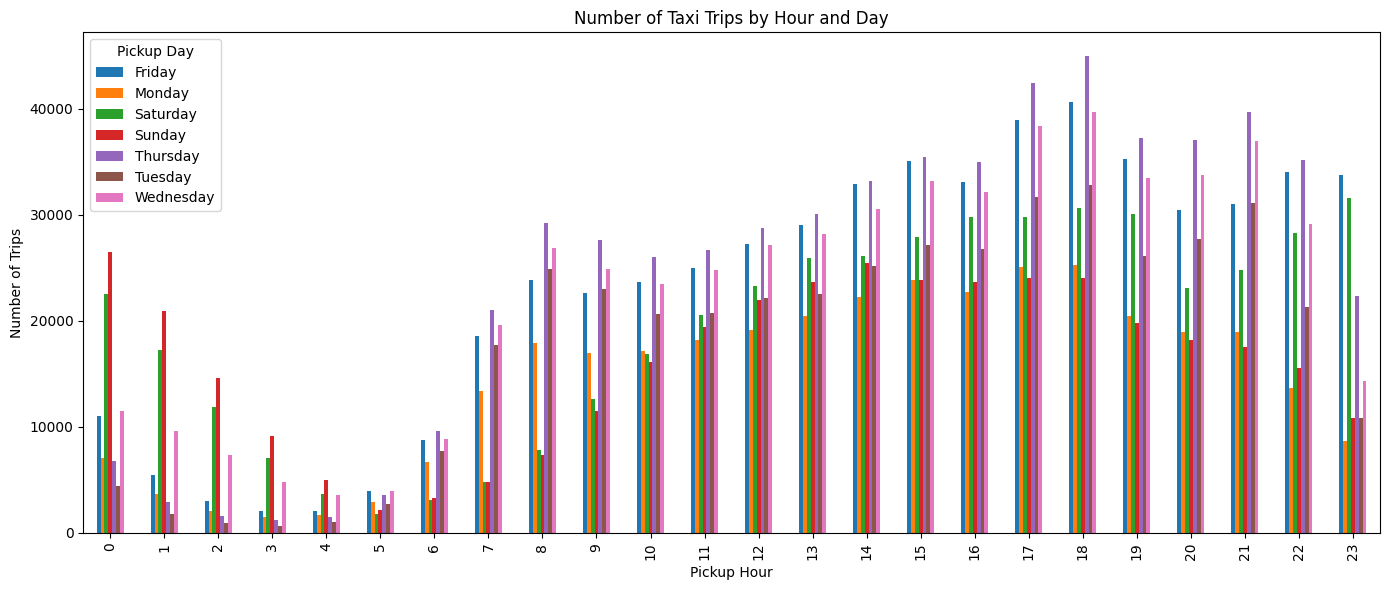

In [6]:
# Extract pickup hour and day from the pickup datetime
df_merged['pickup_hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['pickup_day'] = df_merged['tpep_pickup_datetime'].dt.day_name()

# Plot trips by pickup hour and pickup day using matplotlib
hour_day_counts = df_merged.groupby(['pickup_hour', 'pickup_day']).size().unstack(fill_value=0)
hour_day_counts.plot(kind='bar', stacked=False, figsize=(14, 6))
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.title('Number of Taxi Trips by Hour and Day')
plt.legend(title='Pickup Day')
plt.tight_layout()
plt.show()

Observation: The number of taxi trips peaks around 18:00 (6 PM) on all days of the week.
Interpretation: This suggests that evening rush hour is the busiest time for taxi usage, likely due to people commuting home from work.

Observation: The lowest number of trips occurs between 3:00 AM and 5:00 AM across all days.
Interpretation: This indicates that late night and early morning hours have the least demand for taxis, possibly due to most people being at home.

Observation: Weekends (Saturday and Sunday) show higher trip counts during late night and early morning hours compared to weekdays.
Interpretation: This may be due to nightlife and social activities extending into the early hours on weekends.

Observation: The overall pattern of trip counts by hour is similar across all days, but Friday and Saturday have slightly higher peaks in the evening.
Interpretation: Increased social and leisure activities on these days likely contribute to higher taxi demand.